# Chapter 9: Predicting Continuous Target Variables with Regression Analysis

*Regression analysis* predict a continuous dependent variable.

## Introducing Linear Regression

### Simple Linear Regression

This is also called *univariate* regression because it models a single feature (called the *explanatory variable*) to predict a continuous *target* (*response varibale*). The relation is mapped as a line:
$$
    y = w_1x+b
$$
Where $b$, the bias variable, is the y-intercept, and $w_1$ is the weight coefficient.  This finds the best fit straight line through the training example. This line is called the *regresison line* with the *vertical offset* (or *residuals*) defined as 
$$
    | \hat{y} - y |
$$

### Multiple Linear Regression

*Multiple linear regression* is a generalization to higher dimensions:
$$
    y = \sum_{i = 1}^m w_ix_i + b = w^Tx + b
$$

This generalization uses the same evaluation and concepts as simple linear regression.

## Loading the Ames Housing Dataset


In [5]:
import pandas as pd
# columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
#            'Central Air', 'Total Bsmt SF', 'SalePrice']
# df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
#                  sep='\t', usecols=columns)
# df.head()

In [6]:
# df.to_csv('ames_housing.txt')

In [7]:
df = pd.read_csv('ames_housing.txt').drop(columns = ['Unnamed: 0'])

In [8]:
df.shape

(2930, 6)

In [9]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [10]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [11]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### Exploring the important characteristics of a dataset

*Exploratory Data Analysis*

*Create a scatterplot matrix*

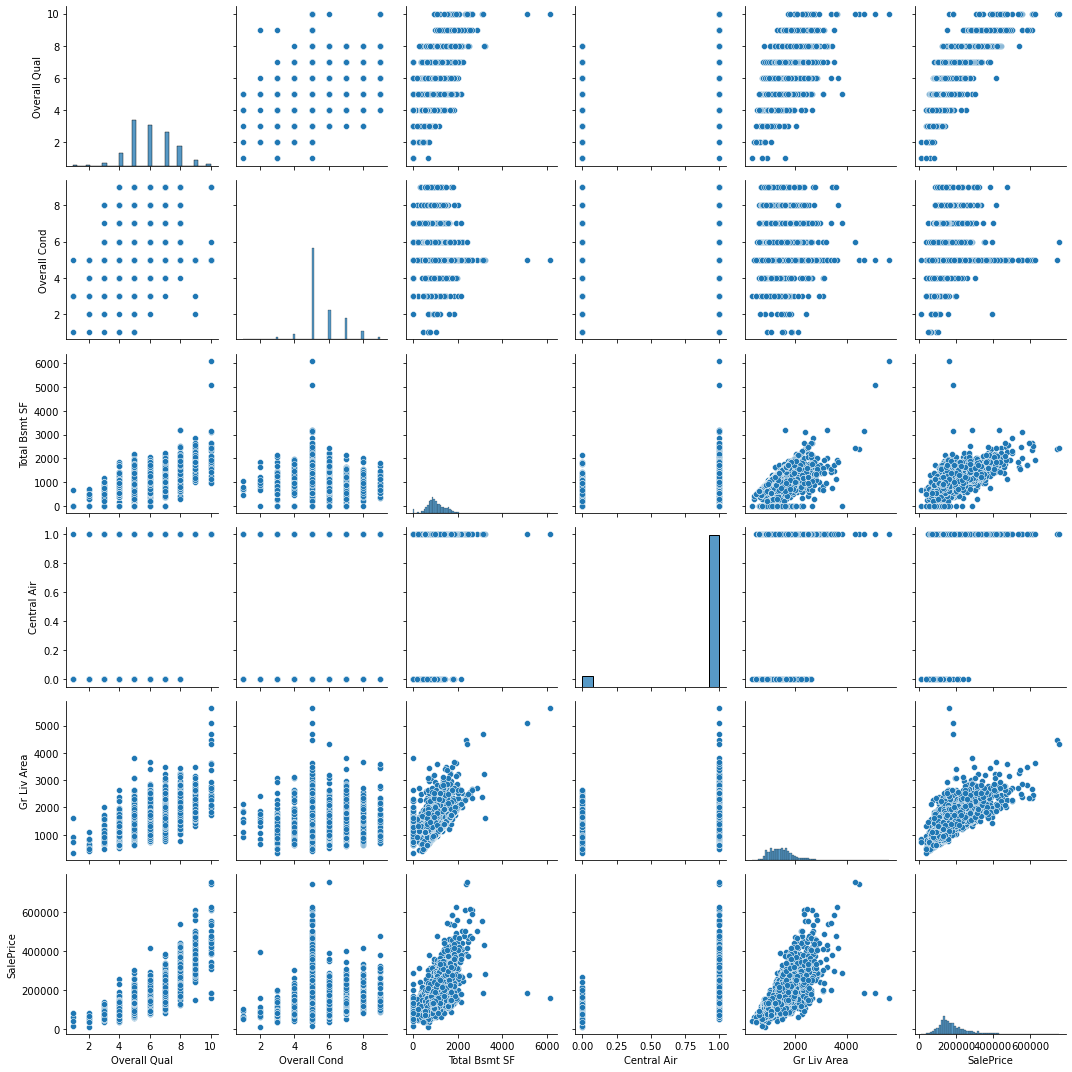

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df)
plt.tight_layout()
plt.show()

### Using a correlation matrix

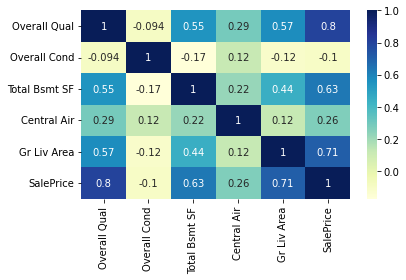

In [17]:
import numpy as np
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.tight_layout()
plt.show()

## Implementing an ordinary least squares linear regression model

*Ordinary Least Squares (OLS)* calculates the line that minimizes the square errors of the regression line.

### Solving regression for regression parameters with gradient descent

Recall the implementation of Adaline, where a Loss function ($L(w, b)$) is minimized and then passed to a threshold function.  Ordinary least squares can be thought of as Adaline without the threshold function. 

In [24]:
class LinearRegressionGD:
    # implement a linear regression that uses gradient descent
    # to minimize the loss function
    
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            error = (y - output)
            #get new weights
            self.w_ += self.eta * 2.0 * X.T.dot(error) / X.shape[0]
            self.b_ += self.eta * 2.0 * error.mean()
            # use square error
            loss = (error**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        return self.net_input(X)

In [25]:
from sklearn.preprocessing import StandardScaler
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() 
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

It is clear how quickly the error minimizes.

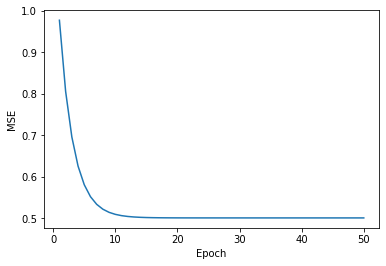

In [26]:
plt.plot(range(1, lr.n_iter+1), lr.losses_) 
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

It is clear that house prices tend to increase as their size increases.

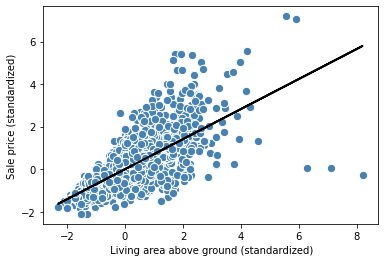

In [27]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

lin_regplot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (standardized)') 
plt.ylabel('Sale price (standardized)')
plt.show()

In [29]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


Predictions can be reverted to the original scale by the `inverse_transform` method of the `StandardScaler`.

In [33]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
target_reverted.flatten()

array([292507.06743664])

## Fitting a robust regression model using RANSAC

*RAndom SAmple Consensus* (RANSAC) is a regression fitting model which fits the model to a subset of the data called *inliers*.  This makes the model less sensitive to outliers.

Algorithm summary:
1. Select a random number of samples to be inliers and fit the model with these.
2. Test the other data points with the fitted model and add the points that are within a user given tolerance to the inliers
3. Refit the model with all inliers
4. Estimate error of fitted model vs inliers
5. Terminate iteration after $n$ steps or when a predetermined performance is met

Implemented in scikit-learn:

In [37]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100, # default value, number of iterations
    min_samples=0.95, #min number of random samples
    residual_threshold=None, # default value ... 
    random_state=123)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

By default the residual threshold is determined by the *median absolute deviation* (MAD) of the target values. However, this is a use-case determined parameter.

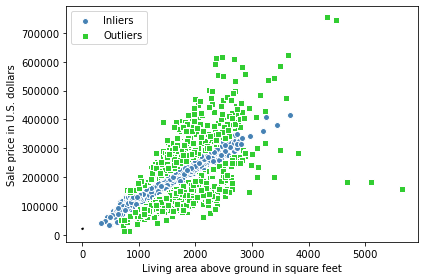

In [38]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis]) 
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2) 
plt.xlabel('Living area above ground in square feet') 
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [41]:
def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data))) 
mean_absolute_deviation(y)

58269.561754979375

If more of the outliers need to be captured, then the `residual_threshold` value can be increased greater than the MAD calculated above.

Note that RANSAC does not determine the effectiveness of the model on unseen data.

## Evaluating the performance of linear regression models

One of the most common ways is *residual plots*; these would show all the points at zero in the case of a perfect prediction.

In [42]:
from sklearn.model_selection import train_test_split 
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train) 
y_test_pred = slr.predict(X_test)

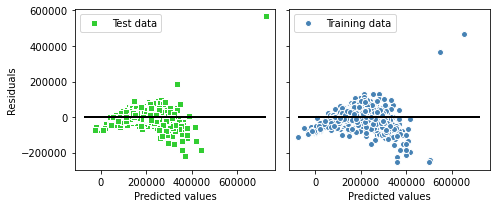

In [45]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)]) 
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(
    y_test_pred, y_test_pred - y_test,
    c='limegreen', marker='s', edgecolor='white',
    label='Test data') 
ax2.scatter(
    y_train_pred, y_train_pred - y_train,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data') 
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,\
    color='black', lw=2) 
plt.tight_layout()
plt.show()

Another metric is the *mean square error* (MSE):
$$
    MSE = \frac{1}{n} \sum_{i=1}^{n} (y^{(i)} - \hat{y}^{(i)})^2
$$

Which can be calculated using scikit learn:

In [46]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train, y_train_pred) 
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


Another is the *mean absolute error*:
$$
    MAE = \frac{1}{n} \sum_{i=1}^{n} |y^{(i)} - \hat{y}^{(i)}|
$$

In [47]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


Note that these metrics are sensitive to scaling and the unit (consider if prices were units in 1K vs units in 1).

This sensitivity sometimes makes the *coefficient of determination* more useful:
$$
    R^2 = 1 - \frac{SSE}{SST}
$$
Where sum of squares errors:
$$
    SSE = \sum_{i=1}^{n} (y^{(i)} - \hat{y}^{(i)})^2
$$
and sum of squares total:
$$
    SST = \sum_{i=1}^{n} (y^{(i)} - \mu_y)^2
$$
i.e. the variance of the response, and is, in fact, just a scaled version of the MSE.

In [48]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

R^2 train: 0.769, 0.752


## Using regularized methods for regression

Recall that regularization helps reduce dimensionality by introducing a penalty against complexity.  There are three main regularization algorithms for regression:
- ridge regression
- least absolute shrinkage and selection operator (LASSO)
- elastic net

*Ridge regression*:
$$
    L(w)_{ridge} = \sum_{i = 1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda\|w\|^2_2
$$
where L2 term is:
$$
    \lambda\|w\|^2_2 = \lambda \sum_{j=1}^m w^2_j
$$


*LASSO*:
$$
    L(w)_{Lasso} = \sum_{i = 1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda\|w\|_1
$$
where L1 term is:
$$
    \lambda\|w\|_1 = \lambda \sum_{j=1}^m |w_j|
$$
Note that LASSO selects at most $n$ features if $m > n$ where $n$ is the number of training examples.  Note that this prevents saturation, which is when the number of training examples and the number of features are equal. This works in LASSO's favor so that there is no overparameterizaiton.

*Elastic net* is a good compromise between *ridge* and *LASSO*:
$$
    L(w)_{Elastic Net} = \sum_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda\|w\|^2_2 + \lambda\|w\|_1
$$

These are all implemented in scikit-learn:

In [49]:
from sklearn.linear_model import Ridge 
ridge = Ridge(alpha=1.0)

In [50]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1.0)

In [51]:
from sklearn.linear_model import ElasticNet  
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

## Turning a linear regression model into a curve - polynomial regression
The relationship might not be linear, but rather a curve:

$$
    y = w_1x + w_2x^2 + \dots + w_dx^d + b
$$

### Adding polynomial terms using scikit-learn

Scikit-learn uses the `PolynomialFeatures` to transform the data.

Add a single degree polynomial term:

In [53]:
from sklearn.preprocessing import PolynomialFeatures 
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0]) [:, np.newaxis]
y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) 
X_quad = quadratic.fit_transform(X)

Use a linear regression model for comparison:

In [54]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis] 
y_lin_fit = lr.predict(X_fit)

Fit the polynomial model:

In [55]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

Plot the results:

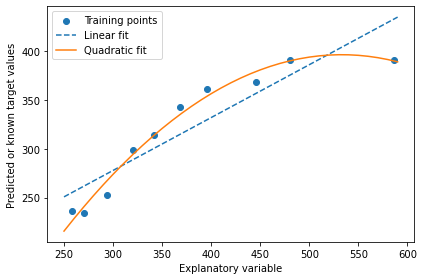

In [56]:
plt.scatter(X, y, label='Training points') 
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--') 
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values') 
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [57]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
mse_lin = mean_squared_error(y, y_lin_pred) 
mse_quad = mean_squared_error(y, y_quad_pred) 
print(f'Training MSE linear: {mse_lin:.3f}'
    f', quadratic: {mse_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330


In [58]:
r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
          f', quadratic: {r2_quad:.3f}')

Training R^2 linear: 0.832, quadratic: 0.982


Note that the quadratic model is significantly better.

### Modeling nonlinear relationships in the Ames Housing dataset

Remove the outliers:

In [59]:
X = df[['Gr Liv Area']].values 
y = df['SalePrice'].values
X = X[(df['Gr Liv Area'] < 4000)] 
y = y[(df['Gr Liv Area'] < 4000)]

In [61]:
regr = LinearRegression()
# create quadratic and cubic features 
quadratic = PolynomialFeatures(degree=2) 
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
# fit to features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis] 
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit)) 
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit)) 
cubic_r2 = r2_score(y, regr.predict(X_cubic))

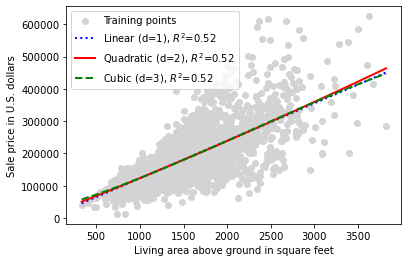

In [62]:
# plot results
plt.scatter(X, y, label='Training points', color='lightgray') 
plt.plot(X_fit, y_lin_fit,
    label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
    color='blue',
    lw=2,
    linestyle=':')
plt.plot(X_fit, y_quad_fit,
    label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
    color='red',
    lw=2,
    linestyle='-')
plt.plot(X_fit, y_cubic_fit,
    label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
    color='green',
    lw=2,
    linestyle='--')
plt.xlabel('Living area above ground in square feet') 
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.show()

Using quadratic and cubic function makes little difference because the relationship is linear. However, if the quality of the house is used, the cubic and quadratic functions fit better.

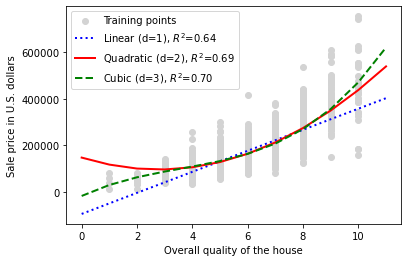

In [65]:
X = df[['Overall Qual']].values 
y = df['SalePrice'].values

regr = LinearRegression()
# create quadratic and cubic features 
quadratic = PolynomialFeatures(degree=2) 
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
# fit to features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis] 
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit)) 
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit)) 
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label='Training points', color='lightgray') 
plt.plot(X_fit, y_lin_fit,
    label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
    color='blue',
    lw=2,
    linestyle=':')
plt.plot(X_fit, y_quad_fit,
    label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
    color='red',
    lw=2,
    linestyle='-')
plt.plot(X_fit, y_cubic_fit,
    label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
    color='green',
    lw=2,
    linestyle='--')
plt.xlabel('Overall quality of the house') 
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.show()

## Dealing with non-linear relationships using random forests

A *random forest regression* can be understood as a sum of piecewise linear functions.  Essentially, it divides the feature space into more manageable sections.

### Decision Tree Regression

Recall chapter 3 and the function for information gain:
$$
    ID(D_p, x_i) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right})
$$
where $x_i$ is the feature, $D$ is the training set, $N$ is the number of examples at a node.  The MSE can be used then as the impurity function:
$$
    I(t) = \frac{1}{N_t} \sum_{i \in D_t} (y^{(i)} - \hat{y}^{(i)})^2
$$

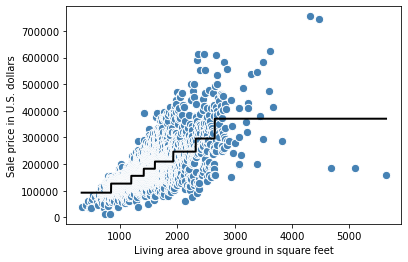

In [67]:
from sklearn.tree import DecisionTreeRegressor 
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet') 
plt.ylabel('Sale price in U.S. dollars')
plt.show()

Note that the regression line gets the general trend, but does not capture the continuity or the differentiability of the data.

### Random Forest Regression

This is an ensemble model along the same lines of the classifier algorithm.

In [69]:
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor( n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred) 
mae_test = mean_absolute_error(y_test, y_test_pred) 
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


Note that there is a tendency to overfit the data. Consider the residuals:

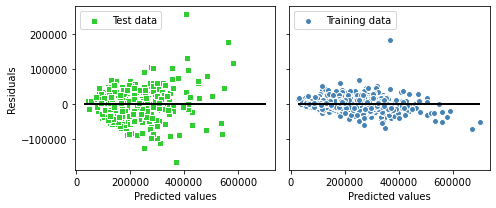

In [70]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)]) 
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test,
    c='limegreen', marker='s', edgecolor='white',
    label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data') 
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,
    color='black', lw=2)
plt.tight_layout() 
plt.show()

Note there is visually an improvement over the linear model, and there is a visual pattern to the residuals.  This indicates that something is not being captured by the model.  Ideally, residuals are random.